## Score, and cross-validated scores

In [25]:
from sklearn import datasets, svm
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

In [2]:
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target

In [3]:
svc = svm.SVC(C=1, kernel='linear')
svc.fit(X_digits[:-100], y_digits[:-100]).score(X_digits[-100:], y_digits[-100:])

0.98

### Split the data into folds

In [16]:
X_folds = np.array_split(X_digits, 3)
y_folds = np.array_split(y_digits, 3)

In [17]:
scores = list()
for k in range(3):
    X_train = list(X_folds)
    X_test = X_train.pop(k)
    X_train = np.concatenate(X_train)
    
    y_train = list(y_folds)
    y_test = y_train.pop(k)
    y_train = np.concatenate(y_train)
    
    scores.append(svc.fit(X_train, y_train).score(X_test, y_test))
    
print(scores)

[0.9348914858096828, 0.9565943238731218, 0.9398998330550918]


In [21]:
# Using KFold

kf = KFold(n_splits=3)
print("Splits: ", kf.get_n_splits(X_digits))
kf

Splits:  3


KFold(n_splits=3, random_state=None, shuffle=False)

In [24]:
scores = list()
for train_index, test_index in kf.split(X_digits):
    X_train, X_test = X_digits[train_index], X_digits[test_index]
    y_train, y_test = y_digits[train_index], y_digits[test_index]
    
    scores.append(svc.fit(X_train, y_train).score(X_test, y_test))
    
print(scores)

[0.9348914858096828, 0.9565943238731218, 0.9398998330550918]


## Cross-validation Generators

In [26]:
cross_val_score(svc, X_digits, y_digits, cv=kf, n_jobs=1)

array([0.93489149, 0.95659432, 0.93989983])

### Exercise: Plot Cross-validation score

In [31]:
C_s = np.logspace(-10, 0, 10)

scores = list()
scores_std = list()

In [32]:
for C in C_s:
    svc.C = C
    this_scores = cross_val_score(svc, X_digits, y_digits)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

In [33]:
scores

[0.15552937214547155,
 0.15552937214547155,
 0.15552937214547155,
 0.15552937214547155,
 0.15552937214547155,
 0.9026027024733573,
 0.9482070815179453,
 0.9449071473407464,
 0.9437997276286755,
 0.9437997276286755]

In [34]:
scores_std

[0.07629246908466533,
 0.07629246908466533,
 0.07629246908466533,
 0.07629246908466533,
 0.07629246908466533,
 0.003217697307891147,
 0.013615673615136992,
 0.009447937924571914,
 0.010287004922697952,
 0.010287004922697952]

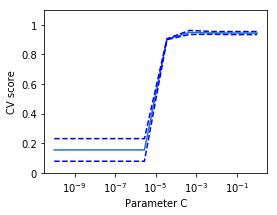

In [36]:
# Do the plotting
import matplotlib.pyplot as plt
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.ylim(0, 1.1)
plt.show()